In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns

In [15]:
# import date range for each winter by day
w22_dates = pd.date_range(start='2021-12-01', end='2022-03-31', freq='D')
w23_dates = pd.date_range(start='2022-12-01', end='2023-03-31', freq='D')

# import large sublimation events
w22_long_sublimation_events = pd.read_csv('./01_data/processed_data/sublimation/w22_large_sublimation_long_events.csv', index_col=0, parse_dates=True)
w22_short_sublimation_events = pd.read_csv('./01_data/processed_data/sublimation/w22_large_sublimation_spiky_events.csv', index_col=0, parse_dates=True)
w22_short_sublimation_events = w22_short_sublimation_events.loc['2022-01-01':'2022-03-31']

w23_long_sublimation_events = pd.read_csv('./01_data/processed_data/sublimation/w23_large_sublimation_long_events.csv', index_col=0, parse_dates=True)
w23_short_sublimation_events = pd.read_csv('./01_data/processed_data/sublimation/w23_large_sublimation_spiky_events.csv', index_col=0, parse_dates=True)

# import precipitation data
w22_precip = pd.read_csv('./01_data/processed_data/precipitation/w22_all_precip_30min.csv', index_col=0, parse_dates=True)
w23_precip = pd.read_csv('./01_data/processed_data/precipitation/w23_all_precip_30min.csv', index_col=0, parse_dates=True)

# import temperature data
w22_met_data = xr.open_dataset('./01_data/processed_data/splash/w22_splash_ap_qc_30min.nc')['temp']
w23_met_data = xr.open_dataset('./01_data/processed_data/sos/sos_ds_30M_storage.nc')['T_3m_c']

# import sublimation data
w22_sublimation = pd.read_csv('./01_data/processed_data/sublimation/w22_winter_sublimation.csv', index_col=0, parse_dates=True).loc['2021-12-01':'2022-03-31']

In [16]:
w22_sublimation

,sublimation_all,sublimation_prcp_0_mm,sublimation_prcp_0_1_mm,sublimation_prcp_0_5_mm,sublimation_prcp_1_mm
2021-12-01 00:00:00,0.010573,0.010573,0.010573,0.010573,0.010573
2021-12-01 00:30:00,-0.001143,-0.001143,-0.001143,-0.001143,-0.001143
2021-12-01 01:00:00,0.007111,0.007111,0.007111,0.007111,0.007111
2021-12-01 01:30:00,-0.001440,-0.001440,-0.001440,-0.001440,-0.001440
2021-12-01 02:00:00,0.001208,0.001208,0.001208,0.001208,0.001208
...,...,...,...,...,...
2022-03-31 21:30:00,0.013806,0.013806,0.013806,0.013806,0.013806
2022-03-31 22:00:00,0.013903,0.013903,0.013903,0.013903,0.013903
2022-03-31 22:30:00,0.018908,0.018908,0.018908,0.018908,0.018908
2022-03-31 23:00:00,0.017493,0.017493,0.017493,0.017493,0.017493


In [4]:
# resample precip to daily totals
w22_precip_daily = w22_precip.resample('D').sum().loc[w22_dates]
w23_precip_daily = w23_precip.resample('D').sum().loc[w23_dates]

# resample temperature to 7D rolling mean
w22_met_data_7d = w22_met_data.resample(time='1D').mean().rolling(time=7).mean().loc[w22_dates]
w23_met_data_7d = w23_met_data.resample(time='1D').mean().rolling(time=7).mean().loc[w23_dates]

In [5]:
sza_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/splash_data/radsys_ckp_dataset.nc')['SZA']
# get max SZA each day
sza_ds_daily = sza_ds.where(sza_ds.time.dt.hour == 19).resample(time='1D').max()
w22_sza = 90-sza_ds_daily.sel(time=w22_dates)
w23_sza = (90-sza_ds_daily.sel(time=w23_dates)).interpolate_na(dim='time')

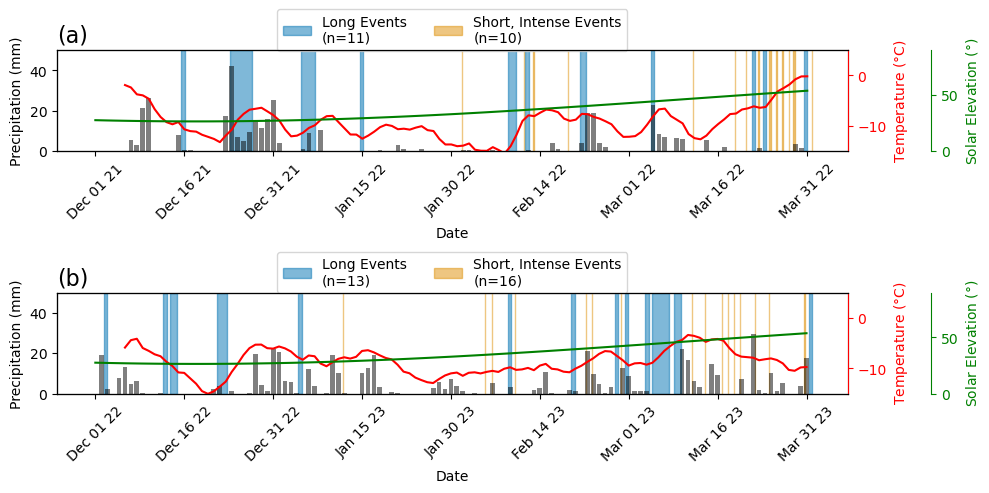

In [6]:
# create figure
fig, axs = plt.subplots(2, 1, figsize= (10,5), tight_layout=True)

# fill the background with the sublimation event spans
for event in w22_long_sublimation_events.event.unique():
    axs[0].axvspan(w22_long_sublimation_events[w22_long_sublimation_events['event'] == event].index[0], 
                   w22_long_sublimation_events[w22_long_sublimation_events['event'] == event].index[-1],
                   color=sns.color_palette(palette='colorblind')[0], 
                   alpha=0.5)
n_long_events = len(w22_long_sublimation_events.event.unique())
for event in w22_short_sublimation_events.event.unique():
    if event > 4:
        axs[0].axvspan(w22_short_sublimation_events[w22_short_sublimation_events['event'] == event].index[0], 
                    w22_short_sublimation_events[w22_short_sublimation_events['event'] == event].index[-1],
                    color=sns.color_palette(palette='colorblind')[1], 
                    alpha=0.5)
n_short_events = len(w22_short_sublimation_events.event.unique()) - 4
# plot a bar plot of precipitation
axs[0].bar(w22_precip_daily.index, w22_precip_daily['SAIL_gts_pluvio'], color='black', alpha=0.5)

# plot a line plot of temperature
ax2_0 = axs[0].twinx()
ax2_0.plot(w22_met_data_7d.time, w22_met_data_7d, color='red')
ax2_0.set_ylim(-15, 5)
ax2_0.set_ylabel('Temperature ($\degree$C)', color='red')

# change color of spine and ticks to match line color
ax2_0.spines['right'].set_color('red')
ax2_0.yaxis.label.set_color('red')
ax2_0.tick_params(axis='y', colors='red')

# plot a line plot of SZA
ax3_0 = axs[0].twinx()
ax3_0.plot(w22_sza.time, w23_sza, color='green')
ax3_0.set_ylim(0, 90)
ax3_0.set_ylabel('Solar Elevation ($\degree$)', color='green')

# move the axis spines to the right
ax3_0.spines['right'].set_position(('outward', 60))
# change color of spine and ticks to match line color
ax3_0.spines['right'].set_color('green')
ax3_0.yaxis.label.set_color('green')
ax3_0.tick_params(axis='y', colors='green')

# rotate x-axis labels
labels = axs[0].set_xticks(w22_precip_daily.index[::15])
axs[0].set_xticklabels(labels=w22_precip_daily.index.strftime('%b %d %y')[::15], rotation=45);

# create a legend for the sublimation events
axs[0].axvspan(None,None, color=sns.color_palette(palette='colorblind')[0], alpha=0.5, label='Long Events\n(n={})'.format(n_long_events))
axs[0].axvspan(None,None, color=sns.color_palette(palette='colorblind')[1], alpha=0.5, label='Short, Intense Events\n(n={})'.format(n_short_events))
axs[0].legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol=2)

# --------------- second plot for 2023 ----------------
# fill the background with the sublimation event spans
for event in w23_long_sublimation_events.event.unique():
    axs[1].axvspan(w23_long_sublimation_events[w23_long_sublimation_events['event'] == event].index[0], 
                   w23_long_sublimation_events[w23_long_sublimation_events['event'] == event].index[-1],
                   color=sns.color_palette(palette='colorblind')[0], 
                   alpha=0.5)
n_long_events = len(w23_long_sublimation_events.event.unique())

for event in w23_short_sublimation_events.event.unique():
    axs[1].axvspan(w23_short_sublimation_events[w23_short_sublimation_events['event'] == event].index[0], 
                   w23_short_sublimation_events[w23_short_sublimation_events['event'] == event].index[-1],
                   color=sns.color_palette(palette='colorblind')[1], 
                   alpha=0.5)
n_short_events = len(w23_short_sublimation_events.event.unique())

axs[1].bar(w23_precip_daily.index, w23_precip_daily['SAIL_gts_pluvio'], color='black', alpha=0.5)

# plot a line plot of temperature
ax2_1 = axs[1].twinx()
ax2_1.plot(w23_met_data_7d.time, w23_met_data_7d, color='red')
ax2_1.set_ylim(-15, 5)
ax2_1.set_ylabel('Temperature ($\degree$C)', color='red')

# change color of spine and ticks to match line color
ax2_1.spines['right'].set_color('red')
ax2_1.yaxis.label.set_color('red')
ax2_1.tick_params(axis='y', colors='red')

# plot a line plot of SEA
ax3_1 = axs[1].twinx()
ax3_1.plot(w23_sza.time, w23_sza, color='green')
ax3_1.set_ylim(0, 90)
ax3_1.set_ylabel('Solar Elevation ($\degree$)', color='green')

# move the axis spines to the right
ax3_1.spines['right'].set_position(('outward', 60))
# change color of spine and ticks to match line color
ax3_1.spines['right'].set_color('green')
ax3_1.yaxis.label.set_color('green')
ax3_1.tick_params(axis='y', colors='green')

# rotate x-axis labels
labels = axs[1].set_xticks(w23_precip_daily.index[::15])
axs[1].set_xticklabels(labels=w23_precip_daily.index.strftime('%b %d %y')[::15], rotation=45);

# add (a) and (b) to the plot titles
axs[0].set_title('(a)', loc='left', size=16)
axs[1].set_title('(b)', loc='left', size=16)

# create a legend for the sublimation events
axs[1].axvspan(None,None, color=sns.color_palette(palette='colorblind')[0], alpha=0.5, label='Long Events\n(n={})'.format(n_long_events))
axs[1].axvspan(None,None, color=sns.color_palette(palette='colorblind')[1], alpha=0.5, label='Short, Intense Events\n(n={})'.format(n_short_events))
axs[1].legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol=2)

# for both axes
for ax in axs:
    ax.set_ylim(0,50)
    ax.set_ylabel('Precipitation (mm)')
    ax.set_xlabel('Date')
    

Text(0.5, 0, 'Date')

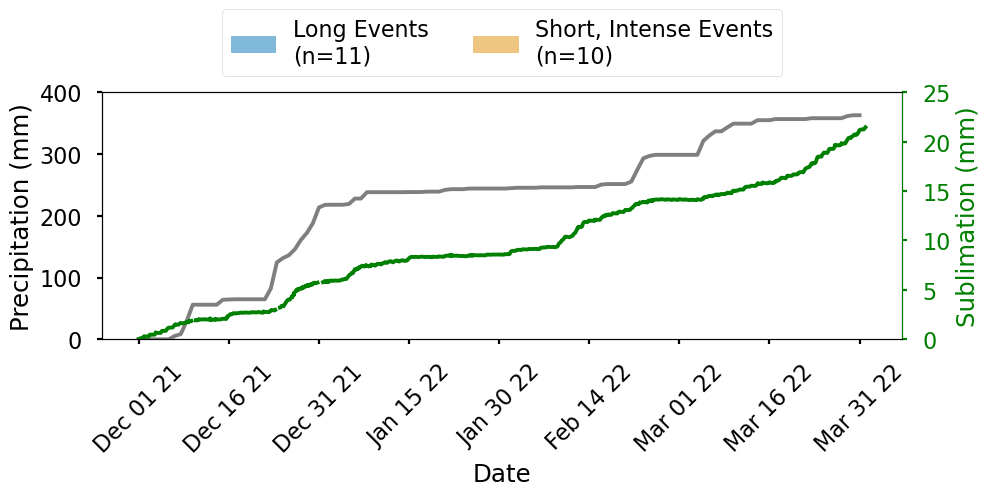

In [30]:
plt.style.use('seaborn-v0_8-poster')
# create figure
fig, axs = plt.subplots(1, 1, figsize= (10,5), tight_layout=True)

# fill the background with the sublimation event spans
# for event in w22_long_sublimation_events.event.unique():
#     axs.axvspan(w22_long_sublimation_events[w22_long_sublimation_events['event'] == event].index[0], 
#                    w22_long_sublimation_events[w22_long_sublimation_events['event'] == event].index[-1],
#                    color=sns.color_palette(palette='colorblind')[0], 
#                    alpha=0.5)
# n_long_events = len(w22_long_sublimation_events.event.unique())
# for event in w22_short_sublimation_events.event.unique():
#     if event > 4:
#         axs.axvspan(w22_short_sublimation_events[w22_short_sublimation_events['event'] == event].index[0], 
#                     w22_short_sublimation_events[w22_short_sublimation_events['event'] == event].index[-1],
#                     color=sns.color_palette(palette='colorblind')[1], 
#                     alpha=0.5)
# n_short_events = len(w22_short_sublimation_events.event.unique()) - 4
# plot a bar plot of precipitation
axs.plot(w22_precip_daily.index, w22_precip_daily['SAIL_gts_pluvio'].cumsum(), color='black', alpha=0.5)

# plot a line plot of SZA
ax3_0 = axs.twinx()
ax3_0.plot(w22_sublimation.index, w22_sublimation['sublimation_prcp_0_5_mm'].cumsum(), color='green')
ax3_0.set_ylim(0, 25)
ax3_0.set_ylabel('Sublimation (mm)', color='green')

# move the axis spines to the right
# change color of spine and ticks to match line color
ax3_0.spines['right'].set_color('green')
ax3_0.yaxis.label.set_color('green')
ax3_0.tick_params(axis='y', colors='green')

# rotate x-axis labels
labels = axs.set_xticks(w22_precip_daily.index[::15])
axs.set_xticklabels(labels=w22_precip_daily.index.strftime('%b %d %y')[::15], rotation=45);

# create a legend for the sublimation events
axs.axvspan(None,None, color=sns.color_palette(palette='colorblind')[0], alpha=0.5, label='Long Events\n(n={})'.format(n_long_events))
axs.axvspan(None,None, color=sns.color_palette(palette='colorblind')[1], alpha=0.5, label='Short, Intense Events\n(n={})'.format(n_short_events))
axs.legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol=2)

# for both axes
axs.set_ylim(0,400)
axs.set_ylabel('Precipitation (mm)')
axs.set_xlabel('Date')
    

In [10]:
# save the figure
plt.savefig('04_products/figures/draft/sublimation_event_summary.png', dpi=300)

<Figure size 640x480 with 0 Axes>